# Training a convolution neural network to classifiy CATS and DOGS

In [4]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os, glob
import pandas as pd # load csv
import zipfile # extract zip
from skimage.external import tifffile # read tiff images
from skimage.transform import resize # resize images

# Preparing the data

In [5]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


Using TensorFlow backend.


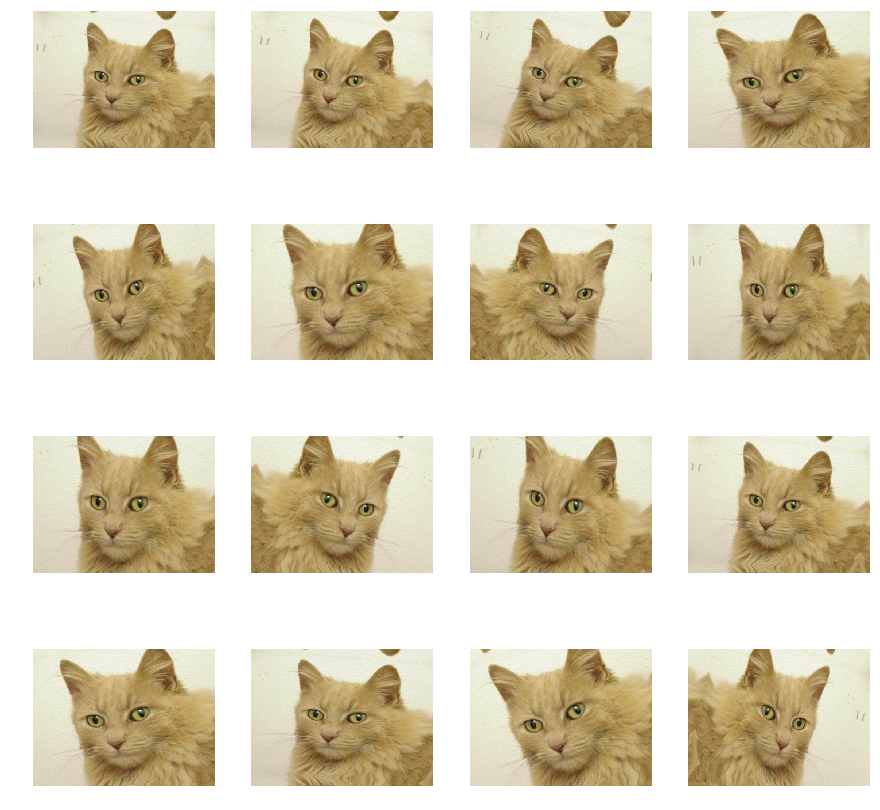

In [6]:
fns = sorted(glob.glob('../data/cats_vs_dogs/train/cats/*.jpg'))
sample = np.random.choice(fns)
img = load_img(sample)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
import shutil
if os.path.exists('../data/cats_vs_dogs/preview'):
    shutil.rmtree('../data/cats_vs_dogs/preview')
os.mkdir('../data/cats_vs_dogs/preview')

i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='../data/cats_vs_dogs/preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 16:
        break  # otherwise the generator would loop indefinitely
        
# read images
fns = sorted(glob.glob('../data/cats_vs_dogs/preview/cat*.jpeg'))
fig, ax = plt.subplots(4,4,figsize=(15,15))
for a, fn in zip(ax.flatten(), fns[:16]):
    a.imshow( load_img(fn) )
    a.axis('off')


Plot some samples from the image data set with titles showing the ground truth labels

# Define a convolutional neural network

In [7]:
def get_cnn(img_height, img_width, num_classes):
    
    from keras.models import Model
    from keras import layers
    
    i = layers.Input(shape=(img_height,img_width,3))
    x = layers.BatchNormalization()(i)
    
    ## Convolutional part
    
    # conv layer with 32 3x3 filters and retified linear activation units
    # Note: first layer requires the specification of an input shape
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    # conv layer with 64 3x3 filters and retified linear activation units
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # conv layer with 128 3x3 filters and retified linear activation units
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # conv layer with 256 3x3 filters and retified linear activation units
    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(x)
    # max pooling with size 2x2
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    ## Multilayer perceptron (MLP) part

    # first, we need to flatten the output of the conv to obtain a vector
    #x = layers.Flatten()(x)
    x = layers.GlobalAveragePooling2D()(x)
    # add a dense NN layer (= fully connected layer of neurons) with ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # dropout layer
    x = layers.Dropout(0.5)(x)
    # add a dense NN layer (= fully connected layer of neurons) with ReLU activation
    x = layers.Dense(128, activation='relu')(x)
    # dropout layer
    x = layers.Dropout(0.5)(x)
    # final layer is equal to the number of classes and uses SoftMax activation 
    o = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=[i], outputs=[o])


def get_vgg(img_height, img_width, num_classes):
    
    from keras import applications
    from keras.models import Model
    from keras import layers
    
    # load a VGG network, pretrained on ImageNet
    vgg = applications.vgg16.VGG16(include_top=False, input_shape=(img_height, img_width, 3))
    
    # freeze all the feature extraction layers
    for i, layer in enumerate(vgg.layers):
        layer.trainable=False

    x = layers.Flatten()(vgg.output)
    #x = layers.GlobalAveragePooling2D()(x)
    # add a dense NN layer (= fully connected layer of neurons) with ReLU activation
    x = layers.Dense(512, activation='relu')(x)
    # dropout layer
    x = layers.Dropout(0.25)(x)
    # add a dense NN layer (= fully connected layer of neurons) with ReLU activation
    x = layers.Dense(256, activation='relu')(x)
    # dropout layer
    x = layers.Dropout(0.25)(x)
    # final layer is equal to the number of classes and uses SoftMax activation 
    o = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs=[vgg.input], outputs=[o])


__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

In [11]:
img_height, img_width = 150,150
model = get_vgg(img_height, img_width, num_classes=2)
from keras import optimizers, losses, metrics
model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# Generators

In [12]:
batch_size = 64

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../data/cats_vs_dogs/train',  # this is the target directory
        target_size=(img_height, img_width),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../data/cats_vs_dogs/validate',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1003 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# Train the neural network

### Train the classifier (leaving feature extraction frozen)

In [13]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch=1003 // batch_size,
                epochs=10,
                validation_data=validation_generator,
                validation_steps=400 // batch_size)

Epoch 1/10
15/15 [==============================] - 6s 411ms/step - loss: 1.0722 - acc: 0.5787 - val_loss: 0.4598 - val_acc: 0.7682
Epoch 2/10
15/15 [==============================] - 6s 411ms/step - loss: 0.5217 - acc: 0.7232 - val_loss: 0.3070 - val_acc: 0.8620
Epoch 3/10
15/15 [==============================] - 6s 402ms/step - loss: 0.3767 - acc: 0.8234 - val_loss: 0.2954 - val_acc: 0.8724
Epoch 4/10
15/15 [==============================] - 5s 353ms/step - loss: 0.3047 - acc: 0.8656 - val_loss: 0.2610 - val_acc: 0.8906
Epoch 5/10
15/15 [==============================] - 6s 368ms/step - loss: 0.2855 - acc: 0.8740 - val_loss: 0.2533 - val_acc: 0.9036
Epoch 6/10
15/15 [==============================] - 5s 343ms/step - loss: 0.3017 - acc: 0.8653 - val_loss: 0.2519 - val_acc: 0.8984
Epoch 7/10
15/15 [==============================] - 5s 348ms/step - loss: 0.2656 - acc: 0.8800 - val_loss: 0.2513 - val_acc: 0.9010
Epoch 8/10
15/15 [==============================] - 5s 337ms/step - loss: 0.

### Unfreeze feature extraction

In [14]:
# freeze all the feature extraction layers
for i, layer in enumerate(model.layers):
    model.trainable=True


In [15]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch=1003 // batch_size,
                epochs=20,
                validation_data=validation_generator,
                validation_steps=400 // batch_size)

Epoch 1/20
15/15 [==============================] - 6s 400ms/step - loss: 0.1783 - acc: 0.9312 - val_loss: 0.2383 - val_acc: 0.9036
Epoch 2/20
15/15 [==============================] - 6s 380ms/step - loss: 0.1611 - acc: 0.9380 - val_loss: 0.2676 - val_acc: 0.9010
Epoch 3/20
15/15 [==============================] - 6s 378ms/step - loss: 0.1716 - acc: 0.9333 - val_loss: 0.2777 - val_acc: 0.9010
Epoch 4/20
15/15 [==============================] - 6s 367ms/step - loss: 0.1663 - acc: 0.9287 - val_loss: 0.2609 - val_acc: 0.9036
Epoch 5/20
15/15 [==============================] - 5s 346ms/step - loss: 0.1572 - acc: 0.9344 - val_loss: 0.2599 - val_acc: 0.9089
Epoch 6/20
15/15 [==============================] - 5s 345ms/step - loss: 0.1389 - acc: 0.9401 - val_loss: 0.2949 - val_acc: 0.9167
Epoch 7/20
15/15 [==============================] - 5s 357ms/step - loss: 0.1419 - acc: 0.9396 - val_loss: 0.2795 - val_acc: 0.8880
Epoch 8/20
15/15 [==============================] - 5s 354ms/step - loss: 0.

In [16]:
model.save('models/cats_dogs_vgg.h5')

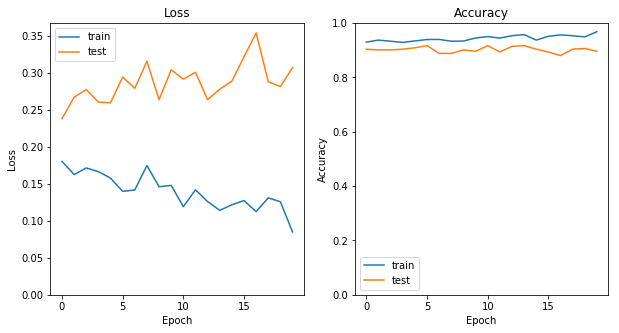

In [17]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax[0].plot(history.history['loss'])
    if validation:
        ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(bottom=0.)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'test'])
    
    # plot history for F score etc.
    ax[1].plot(history.history['acc'])
    if validation:
        ax[1].plot(history.history['val_acc'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylim(bottom=0., top=1.0)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'test'])

plot_history(history, validation=True)

In [18]:
score = model.evaluate_generator(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.321959600449
Test accuracy: 0.8925


In [19]:
for i, l in enumerate(model.layers):
    print(i, l.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_2
20 dense_4
21 dropout_3
22 dense_5
23 dropout_4
24 dense_6


# Visualize class activation map

Based on [`keras-vis`](https://raghakot.github.io/keras-vis/)

In [20]:

from vis.visualization import visualize_cam, overlay
from vis.utils import utils
from keras import activations
from matplotlib import cm

model_vis = utils.apply_modifications(model)


..........

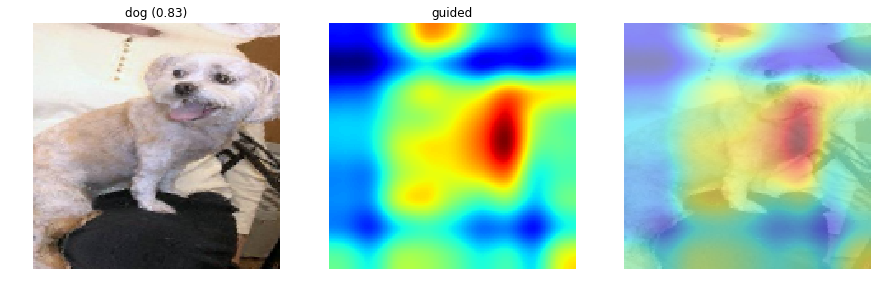

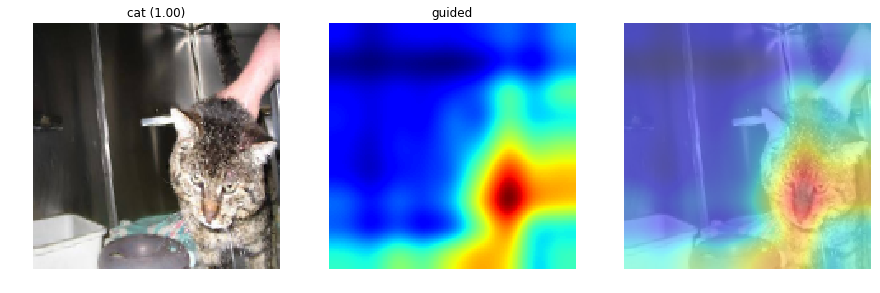

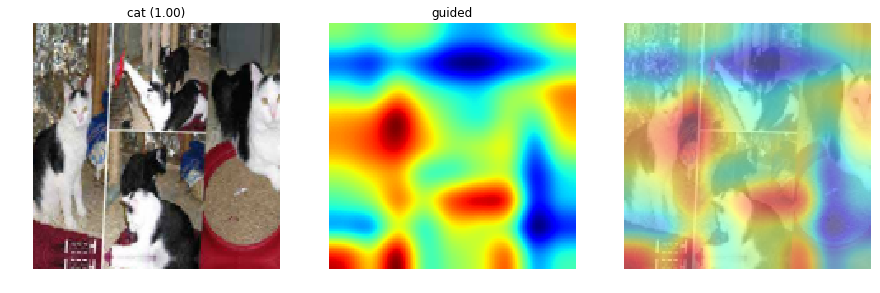

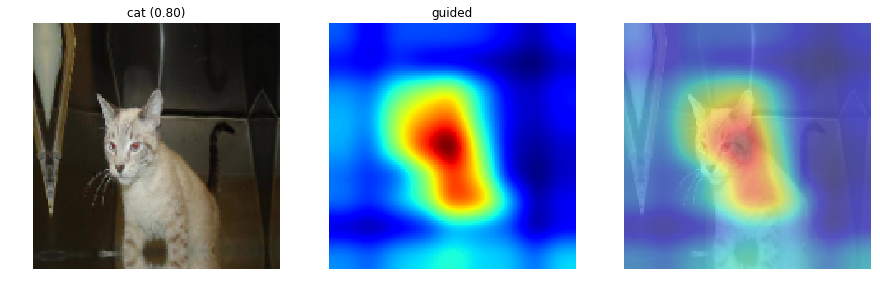

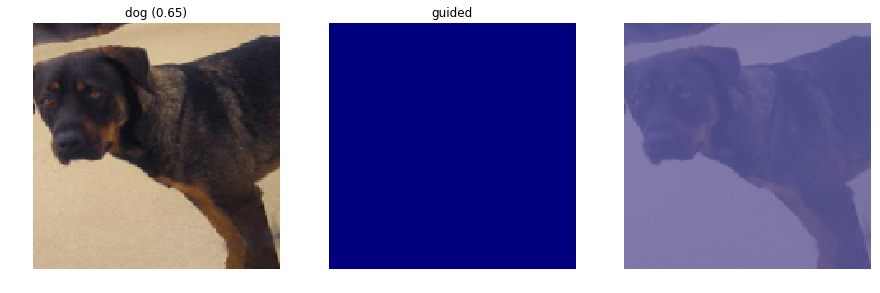

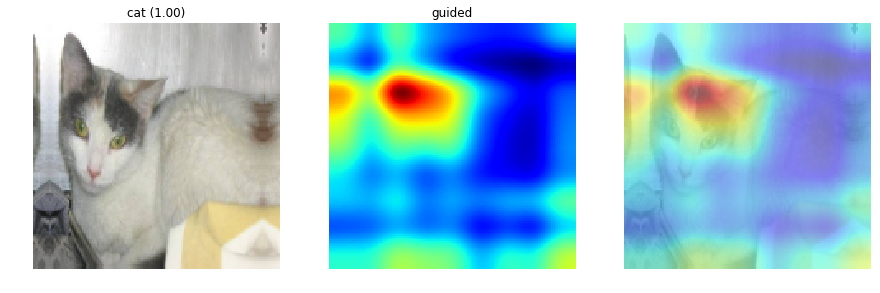

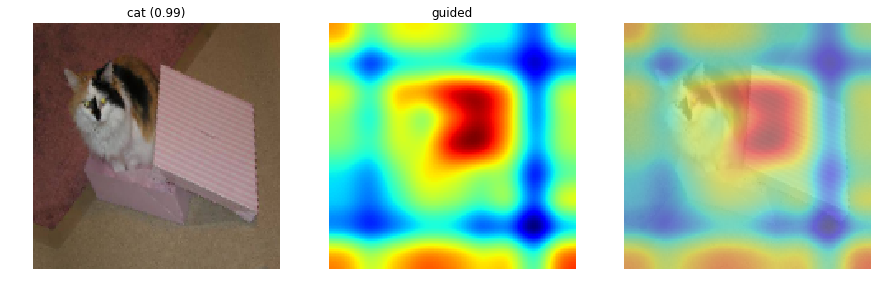

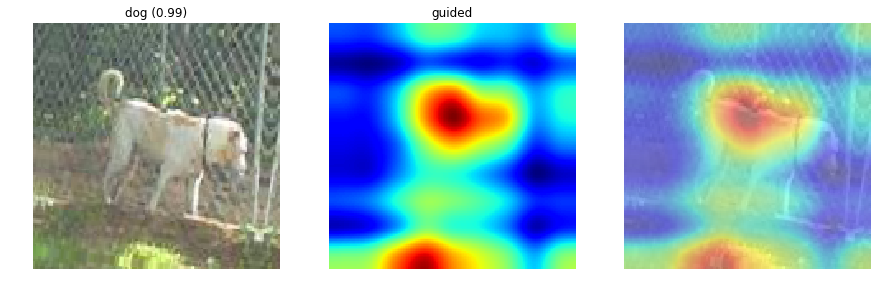

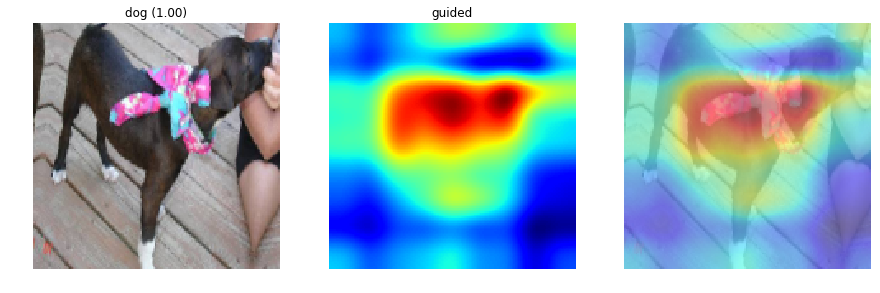

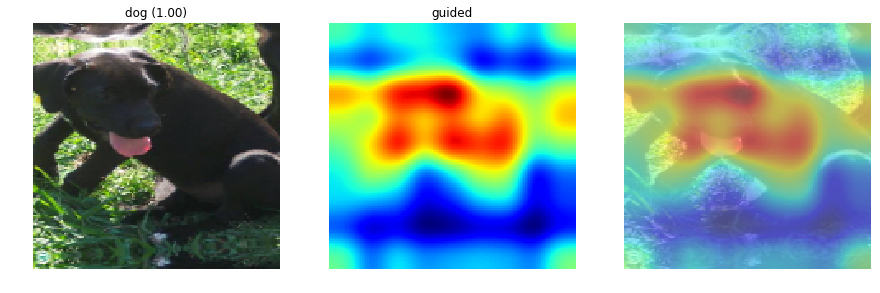

In [23]:

n = 10
for i in np.arange(n):
    print('.', end='')
    batch =  next(train_generator)
    #print(batch[1])
    sample    = np.random.choice(range(len(batch)))
    image     = batch[0][sample]
    #print(image.shape)
    class_idx = np.argmax(batch[1][sample], axis=-1)
    
    #print("class_idx = ", class_idx)
    
    #if class_idx == 0: class_idx = 1
    #elif class_idx == 1: class_idx = 0
    
    pred = model.predict(np.expand_dims(image,0))[0]
    f, ax = plt.subplots(1, 3, figsize=(15,5*n))
    ax[0].imshow(image)
    if np.argmax(pred) == 0:
        ax[0].set_title('cat ({:.2f})'.format(pred.max()))
    else:
        ax[0].set_title('dog ({:.2f})'.format(pred.max()))
    #print('pred     = ', np.argmax(pred))
    
    
    for i, modifier in enumerate(['guided']): #[None, 'guided', 'relu']
        grads = visualize_cam(model_vis, layer_idx=-1, penultimate_layer_idx=17, filter_indices=class_idx, 
                              seed_input=image, backprop_modifier=modifier, grad_modifier='absolute')        
        if modifier is None:
            modifier = 'none'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')
        jet_heatmap = np.uint8(cm.jet(grads)[...,]*255)
        #print(jet_heatmap.shape)
        #print(image.shape)
        ax[2].imshow(overlay(grads, ((image+1.0)/2.0)*255, alpha=0.45))
        
    for a in ax: a.axis('off')
